In [1]:
import pandas as pd
import sys
import pickle
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
from matplotlib import pyplot as plt
import numpy as np
import itertools
from scipy.ndimage import gaussian_filter1d
import multiprocessing
from joblib import Parallel, delayed
import glob as glob
from scipy.stats import poisson,zscore
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency 
from scipy import signal
from itertools import groupby



Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

In [3]:
def gaussFilt(X, wdim = (1,)):
	'''
		Gaussian Filtering in 1 or 2d.		
		Made to fit matlab
	'''
	from scipy.signal import gaussian

	if len(wdim) == 1:
		from scipy.ndimage.filters import convolve1d
		l1 = len(X)
		N1 = wdim[0]*10
		S1 = (N1-1)/float(2*5)
		gw = gaussian(N1, S1)
		gw = gw/gw.sum()
		#convolution
		if len(X.shape) == 2:
			filtered_X = convolve1d(X, gw, axis = 1)
		elif len(X.shape) == 1:
			filtered_X = convolve1d(X, gw)
		return filtered_X	
	elif len(wdim) == 2:
		from scipy.signal import convolve2d
		def conv2(x, y, mode='same'):
			return np.rot90(convolve2d(np.rot90(x, 2), np.rot90(y, 2), mode=mode), 2)			

		l1, l2 = X.shape
		N1, N2 = wdim		
		# create bordered matrix
		Xf = np.flipud(X)
		bordered_X = np.vstack([
				np.hstack([
					np.fliplr(Xf),Xf,np.fliplr(Xf)
				]),
				np.hstack([
					np.fliplr(X),X,np.fliplr(X)
				]),
				np.hstack([
					np.fliplr(Xf),Xf,np.fliplr(Xf)
				]),
			])
		# gaussian windows
		N1 = N1*10
		N2 = N2*10
		S1 = (N1-1)/float(2*5)
		S2 = (N2-1)/float(2*5)
		gw = np.vstack(gaussian(N1,S1))*gaussian(N2,S2)
		gw = gw/gw.sum()
		# convolution
		filtered_X = conv2(bordered_X, gw, mode ='same')
		return filtered_X[l1:l1+l1,l2:l2+l2]
	else :
		print("Error, dimensions larger than 2")
		return
  

In [4]:
def get_raster_points(spikes,peak_time):
    ''' 
    create raster centered over each ripple with a 1 second window
    '''
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))
    return x, y

def get_h0_z_energy(x,y,binsize=0.005,window=30):
     # bin cell into 5ms bins 
    h0_counts, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0_counts / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,window)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, h0_counts

def swr_modulation(spikes,peak_time,session_range,binsize=0.005,window=30):
    '''
        swr modulation cross-correlograms based on Viejo & Peyrache 2020
    '''
    # get observed values
    x, y = get_raster_points(spikes,peak_time)
    
    h0, z, swr_energy, h0_counts = get_h0_z_energy(x,y,binsize=binsize,window=window)
    
    # get null data based on random peak times
    peak_time_null = np.random.uniform(low=session_range[0], high=session_range[1], size=(len(peak_time),))
    x, y = get_raster_points(spikes,peak_time_null)
    
    h0_null, z_null, swr_energy_null, h0_counts_null = get_h0_z_energy(x,y,binsize,window)
    
    return h0, z, swr_energy, h0_counts, h0_null, z_null, swr_energy_null, h0_counts_null

def shuff_spikes(s,session_range,n_shuff=400):
    '''
    shuffles spike train by -+ session duration
    '''
    # find random uniform intervals to shift spike times
    surrogate = np.random.choice(np.arange(-session_range[1],session_range[1]), size=n_shuff,replace=False)
    shuff_spks = []
    for n in surrogate:
        # offset spike times
        new_s = s + n
        # wrap spike times that are outside the range of session
        if np.any(new_s > session_range[1]):
            idx = new_s > session_range[1]
            new_s = np.hstack([new_s[idx] - min(new_s[idx]),new_s[idx==False]])
        elif np.any(new_s < session_range[0]):
            idx = new_s < session_range[0]
            new_s = np.hstack([new_s[idx==False],new_s[idx] + max(new_s) + -n])

        shuff_spks.append(new_s)
    return shuff_spks

def find_consecutive(L,length=4):
    '''
    gives true or false if binary vector L has consective 1s for at 
    least length n (default=4)
    '''
    grouped_L = [(k, sum(1 for i in g)) for k,g in groupby(L)]
    grouped_L

    n_contig = []
    for item in grouped_L:
        if item[0] == 1:
            n_contig.append(item[1])  
    return np.any(np.array(n_contig) >= length)

def surrogate_test(s,h0,session_range,peak_time,conf=95):
    '''
    shuffle methods from Azahara et al. 2016 to find significant ripple modulation
    of individual units
    '''
    
    shuff_spks = shuff_spikes(s,session_range)

    null = []
    for new_s in shuff_spks:
        x, y = get_raster_points(new_s, peak_time)
        cur_h0, _, _, _ = get_h0_z_energy(x,y)
        null.append(cur_h0)

    null = np.array(null)
    shuff_hibound = np.percentile(null, conf, axis=0)
    shuff_lobound = np.percentile(null, 100-conf, axis=0)
    
    hi_pass = find_consecutive((h0 > shuff_hibound) * 1)
    low_pass = find_consecutive((h0 < shuff_lobound) * 1)
    
    return hi_pass,low_pass,shuff_hibound,shuff_lobound

def get_participation_prob(s,df_swr):
    '''
    The probability of participation: number of events in which a unit 
    fired at least one spike during the ripple divided by the total
    number of ripples detected.
    '''
    spk_in_range = []
    for event in df_swr.itertuples():
        spk_in_range.append(np.any(((s >= event.start_time) & (s <= event.end_time))))
        
    return sum(spk_in_range)/len(df_swr.session)


In [6]:
def main_loop(session,df_swr,data_path,save_path):
    
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
    
    h0_all = []
    z_all = []
    swr_energy_all = []
    h0_counts_all = []
    
    h0_null_all = []
    z_null_all = []
    swr_energy_null_all = []
    h0_counts_null_all = []
    
    hi_pass_all = []
    low_pass_all = []
    shuff_hibound_all = []
    shuff_lobound_all = []
    
    participation_prob_all = []
    
    # find index of first mention of session
    rip_n = np.where(df_swr.session == session)[0][0]
    # load spikes
    spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
    # get ripple times
    peak_time = df_swr.peak_time[df_swr.session == session]
    # get session range
    spikes_ = list(itertools.chain(*spikes))
    session_range = [min(spikes_),max(spikes_)]
    
    # loop through each cell and get modulation 
    for s in spikes:
        h0, z, swr_energy, h0_counts, h0_null, z_null, swr_energy_null, h0_counts_null = swr_modulation(s,peak_time,session_range)
        hi_pass, low_pass, shuff_hibound, shuff_lobound = surrogate_test(s,h0,session_range,peak_time)

        participation_prob = get_participation_prob(s,df_swr[df_swr.session == session])
    
        h0_all.append(h0)
        z_all.append(z)
        swr_energy_all.append(swr_energy)
        h0_counts_all.append(h0_counts)

        h0_null_all.append(h0_null)
        z_null_all.append(z_null)
        swr_energy_null_all.append(swr_energy_null)
        h0_counts_null_all.append(h0_counts_null)

        hi_pass_all.append(hi_pass)
        low_pass_all.append(low_pass)
        shuff_hibound_all.append(shuff_hibound)
        shuff_lobound_all.append(shuff_lobound)
        
        participation_prob_all.append(participation_prob)


    with open(save_file, 'wb') as f:
        pickle.dump(h0_all, f)
        pickle.dump(z_all, f)  
        pickle.dump(swr_energy_all, f)  
        pickle.dump(h0_counts_all, f)  
        pickle.dump(h0_null_all, f)
        pickle.dump(z_null_all, f)  
        pickle.dump(swr_energy_null_all, f) 
        pickle.dump(h0_counts_null_all, f) 
        pickle.dump(hi_pass_all, f)
        pickle.dump(low_pass_all, f)  
        pickle.dump(shuff_hibound_all, f) 
        pickle.dump(shuff_lobound_all, f) 
        pickle.dump(participation_prob_all, f) 


project_path = 'F:/Projects/PAE_PlaceCell/'
analysis_path = project_path+'analysis/'
data_path = project_path+'ProcessedData/'          
save_path = analysis_path+"ripple_modulation/"
df_swr = pd.read_csv(analysis_path+'swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(analysis_path+'cell_recruitment/processed/pyr_int_df.csv')

sessions = pd.unique(df_swr.session)

num_cores = multiprocessing.cpu_count()         
processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(session,df_swr,data_path,save_path) for session in sessions)


# for session in sessions:
#     print(session)
#     main_loop(session,df_swr,data_path,save_path)

# read back in results per session

In [7]:
project_path = 'F:/Projects/PAE_PlaceCell/'
analysis_path = project_path+'analysis/'
data_path = project_path+'ProcessedData/'          
save_path = analysis_path+"ripple_modulation/"
df_swr = pd.read_csv(analysis_path+'swr_data/post_processed/swr_df.csv')
df_cell_class = pd.read_csv(analysis_path+'cell_recruitment/processed/pyr_int_df.csv')

def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + '*.pkl')
    h0 = []
    z = []
    swr_energy = []
    h0_counts = []

    h0_null = []
    z_null = []
    swr_energy_null = []
    h0_counts_null = []
    
    hi_pass = []
    low_pass = []
    shuff_hibound = []
    shuff_lobound = []
    participation_prob = []
    
    mod_dict = {}

    for session in sessions:
        with open(session, 'rb') as f:
            h0.append(pickle.load(f))
            z.append(pickle.load(f))
            swr_energy.append(pickle.load(f))
            h0_counts.append(pickle.load(f))
            h0_null.append(pickle.load(f))
            z_null.append(pickle.load(f))
            swr_energy_null.append(pickle.load(f))
            h0_counts_null.append(pickle.load(f))

            hi_pass.append(pickle.load(f))
            low_pass.append(pickle.load(f))
            shuff_hibound.append(pickle.load(f))
            shuff_lobound.append(pickle.load(f))
            participation_prob.append(pickle.load(f))
        
    swr_energy = list(itertools.chain(*swr_energy))
    h0 = np.vstack(h0)
    z = np.vstack(z)
    h0_counts = np.vstack(h0_counts)

    swr_energy_null = list(itertools.chain(*swr_energy_null))
    h0_null = np.vstack(h0_null)
    z_null = np.vstack(z_null)
    h0_counts_null = np.vstack(h0_counts_null)
    
    participation_prob = list(itertools.chain(*participation_prob))
    hi_pass = list(itertools.chain(*hi_pass))
    low_pass = list(itertools.chain(*low_pass))
    shuff_hibound = np.vstack(shuff_hibound)
    shuff_lobound = np.vstack(shuff_lobound)

    mod_dict = {
        "h0": h0,
        "z": z,
        "swr_energy": swr_energy,
        "h0_counts": h0_counts,
        "h0_null": h0_null,
        "z_null": z_null,
        "swr_energy_null": swr_energy_null,
        "h0_counts_null": h0_counts_null,
        "participation_prob": participation_prob,
        "hi_pass": hi_pass,
        "low_pass": low_pass,
        "shuff_hibound": shuff_hibound,
        "shuff_lobound": shuff_lobound
    }
    return mod_dict

mod_dict = load_in_everything(save_path)
mod_dict.keys()

dict_keys(['h0', 'z', 'swr_energy', 'h0_counts', 'h0_null', 'z_null', 'swr_energy_null', 'h0_counts_null', 'participation_prob', 'hi_pass', 'low_pass', 'shuff_hibound', 'shuff_lobound'])

### check to see if all data is present

In [220]:
print(mod_dict['h0'].shape)
print(mod_dict['z'].shape)
print(len(mod_dict['swr_energy']))
print(mod_dict['h0_counts'].shape)
print(mod_dict['h0_null'].shape)
print(mod_dict['z_null'].shape)
print(len(mod_dict['swr_energy_null']))
print(mod_dict['h0_counts_null'].shape)
print(len(mod_dict['participation_prob']))
print(len(mod_dict['hi_pass']))
print(len(mod_dict['low_pass']))
print(mod_dict['shuff_hibound'].shape)
print(mod_dict['shuff_lobound'].shape)
print(df_cell_class.shape)

(8407, 199)
(8407, 199)
8407
(8407, 199)
(8407, 199)
(8407, 199)
8407
(8407, 199)
8407
8407
8407
(8407, 199)
(8407, 199)
(8407, 41)


# Add metrics to df

In [12]:
# metrics from analysis
df_cell_class['swr_energy'] = mod_dict['swr_energy']
df_cell_class['participation_prob'] = mod_dict['participation_prob']
df_cell_class['hi_pass'] = mod_dict['hi_pass']
df_cell_class['low_pass'] = mod_dict['low_pass']

# group
control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

df_cell_class['group'] = np.ones_like(df_cell_class.session)

regstr = '|'.join(control)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.loc[idx,'group'] = 'control'

regstr = '|'.join(pae)
idx = df_cell_class['session'].str.upper().str.contains(regstr)    
df_cell_class.loc[idx,'group'] = 'pae'

# number of ripples 
n_ripples = [sum(df_swr.session == session) for session in df_cell_class.session]
df_cell_class['n_ripples'] = n_ripples

# number of spikes in the 1 second window around ripples
n_spikes_in_rip_window = [cch.sum() for cch in mod_dict['h0_counts']] 
df_cell_class['n_spikes_in_rip_window'] = n_spikes_in_rip_window

### restrict to HPC

In [ ]:
idx = (df_cell_class['area'] == 'ca1') | (df_cell_class['area'] == 'ca3')

df_cell_class = df_cell_class[idx]
mod_dict['h0'] = mod_dict['h0'][idx]
mod_dict['z'] = mod_dict['z'][idx]
mod_dict['swr_energy'] = np.array(mod_dict['swr_energy'])[idx]
mod_dict['h0_counts'] = mod_dict['h0_counts'][idx]
mod_dict['h0_null'] = mod_dict['h0_null'][idx]
mod_dict['z_null'] = mod_dict['z_null'] [idx]
mod_dict['swr_energy_null'] = np.array(mod_dict['swr_energy_null'])[idx]
mod_dict['h0_counts_null'] = mod_dict['h0_counts_null'][idx]
mod_dict['participation_prob'] = np.array(mod_dict['participation_prob'])[idx]
mod_dict['hi_pass'] = np.array(mod_dict['hi_pass'])[idx]
mod_dict['low_pass'] = np.array(mod_dict['low_pass'])[idx]
mod_dict['shuff_hibound'] = mod_dict['shuff_hibound'][idx]
mod_dict['shuff_lobound'] = mod_dict['shuff_lobound'][idx]

## convolution method of finding sig peaks or troughs

don't run... relying on the shuffle analysis for now
 

In [324]:
# def local_firfilt( x, W ):
#     C = int(len(W))
#     D = int(np.ceil(C / 2) - 1)
#     xx = [np.flipud(x[:C]), x, np.flipud(x[-C:])]
#     xx = list(itertools.chain(*xx))
#     Y = signal.lfilter(W,1,xx)
#     Y = Y[C + D : len(Y) - C + D]
#     return Y

# def local_gausskernel(sigma,N):
#     x = np.arange(-(N-1) / 2, ((N-1) / 2) + 1)
#     k = 1 / (2*np.pi*sigma) * np.exp(-(x**2 / 2 / sigma**2 ))
#     return k

# def cch_conv(cch,W=30,HF=0.6):
#     # Stark and Abeles JNM 2009
#     SDG = W / 2
#     if round(SDG)==SDG: # even W
#         win = local_gausskernel(SDG, 6 * SDG + 1)
#         cidx = int(SDG * 3 + 1)
#     else:
#         win = local_gausskernel(SDG, 6 * SDG + 2) 
#         cidx = int(SDG * 3 + 1.5)
#     win[cidx-1] = win[cidx-1] * ( 1 - HF )
#     win = win / sum( win )
#     pred = local_firfilt( cch, win )
#     pvals = 1 - poisson.cdf(cch - 1, pred) - poisson.pmf(cch, pred) * 0.5
#     qvals = 1 - pvals
#     return pvals, pred, qvals

# def sig_mod(cch,binsize=0.005,sig_window=0.2,alpha=0.001,W=30):
#     # check and correct for negative values
#     if np.any(cch<0):
#         cch = cch + np.abs(min(cch))
    
#     pvals, pred, qvals = cch_conv(cch,W)

#     nBonf = int(sig_window/binsize)*2;
#     hiBound = poisson.ppf(1-alpha/nBonf, pred)
#     loBound = poisson.ppf(alpha/nBonf, pred)

#     center_bins = np.arange(int(len(cch)/2 - .1/binsize), int(len(cch)/2 + .1/binsize))
#     # at least 2 bins more extreme than bound to be sig
#     sig = (sum(cch[center_bins] > max(hiBound))>2) | (sum(cch[center_bins] < min(loBound))>2)
#     return sig, hiBound, loBound, pvals, pred

# # sig, hiBound, loBound, pvals, pred = sig_mod(hist,alpha=0.05)
# sig, hiBound, loBound, pvals, pred = zip(*[sig_mod(cch,alpha=0.05) for cch in mod_dict['z']])
# df_cell_class['sig_center'] = sig

In [15]:
idx = (df_cell_class.n_ripples >= 100) & (df_cell_class.n_spikes >= 100) & ((df_cell_class.hi_pass == True) | (df_cell_class.low_pass == True))
# temp_df = df_cell_class[idx]

np.sum(idx)

1230

# Ripple modulation figure

In [222]:
from scipy import stats
mod_dict['h0_zscore'] = stats.zscore(mod_dict['h0'],axis=1)

In [191]:
import matplotlib as mpl

class MidpointNormalize(mpl.colors.Normalize):
    '''
    https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    '''
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

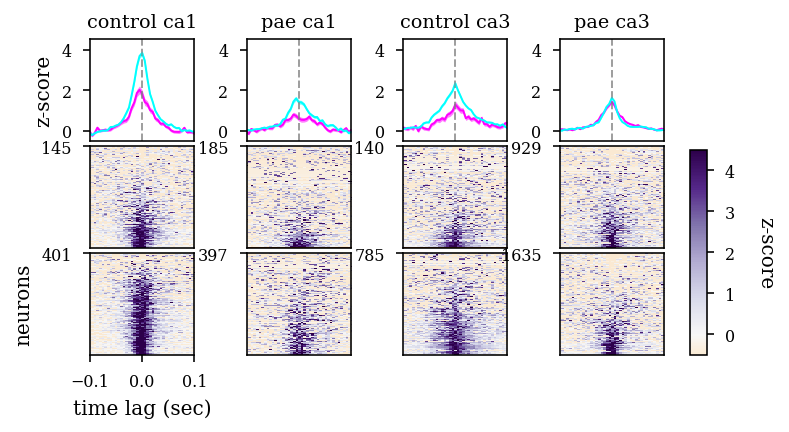

In [269]:
n_ripples = 50
n_spikes = 100
# good_cells = ((df_cell_class.n_ripples >= n_ripples) &
#               (df_cell_class.n_spikes >= n_spikes) &
#               ((df_cell_class.hi_pass == True) | (df_cell_class.low_pass == True)))

good_cells = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes))

def plot_mod_matrix(df_cell_class,mod_dict,good_cells,group,area,cell_type,ax,x_off=False):
    norm = MidpointNormalize(vmin=-0.5, vmax=4.5, midpoint=0)

    h0_current = mod_dict['h0_zscore'][good_cells &
                           (df_cell_class.cell_type == cell_type) &
                           (df_cell_class.area == area) &
                           (df_cell_class.group == group)]
    # get and sort by mean of center 3 columns
    center_idx = int(h0_current.shape[1]/2)
    idx = np.mean(h0_current[:,center_idx-1:center_idx+2],axis=1)
    idx = np.argsort(idx)
    # get x axis
    extent = [-.5 , .5, 0 , len(idx)]
    # plot matrix
    ax.imshow(h0_current[idx,:],aspect='auto',extent=extent,cmap=plt.get_cmap('PuOr'),norm=norm)
    # restrict to +-100ms
    ax.set_xlim(-0.1,0.1)
    ax.set_yticks([h0_current.shape[0]])
    if x_off:
        ax.axes.get_xaxis().set_ticks([])
    
def plot_mod_mean_std(df_cell_class,mod_dict,good_cells,group,area,cell_type,ax,color):
    h0_current = mod_dict['h0_zscore'][good_cells &
                       (df_cell_class.cell_type == cell_type) &
                       (df_cell_class.area == area) &
                       (df_cell_class.group == group)]
    x = np.linspace(-.5,.5,mod_dict['h0'].shape[1]) 
    m = np.nanmean(h0_current,axis=0)
    v = np.nanstd(h0_current,axis=0) / np.sqrt(h0_current.shape[0])
    ax.plot(x,m, color = color, linewidth = 1)
    ax.fill_between(x, m-v, m+v, color = color, alpha = 0.5, linewidth = 0)
    ax.axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
    ax.set_title(group+' '+area)
    ax.set_xlim(-0.1,0.1)
    ax.set_ylim(-.5,4.5)
    ax.axes.get_xaxis().set_ticks([])
    

fig, axs = plt.subplots(3,4, figsize=set_size('thesis', fraction=1, subplots=(3,4)), edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.5)
ax = axs.ravel()  

cmap = plt.get_cmap("cool_r",2)

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca1','int',ax[0],cmap(0))
ax[0].set_ylabel('z-score')

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca1','pyr',ax[0],cmap(1))

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca1','int',ax[1],cmap(0))
plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca1','pyr',ax[1],cmap(1))

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca3','int',ax[2],cmap(0))
plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'control','ca3','pyr',ax[2],cmap(1))

plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca3','int',ax[3],cmap(0))
plot_mod_mean_std(df_cell_class,mod_dict,good_cells,'pae','ca3','pyr',ax[3],cmap(1))


plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca1','int',ax[4],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca1','pyr',ax[8])
ax[8].set_xlabel('time lag (sec)')
ax[8].set_ylabel('neurons')

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca1','int',ax[5],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca1','pyr',ax[9],True)

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca3','int',ax[6],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'control','ca3','pyr',ax[10],True)

plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca3','int',ax[7],True)
plot_mod_matrix(df_cell_class,mod_dict,good_cells,'pae','ca3','pyr',ax[11],True)

import matplotlib as mpl

norm = MidpointNormalize(vmin=-0.5, vmax=4.5, midpoint=0)

# norm = mpl.colors.Normalize(vmin=-0.5, vmax=4.5)
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('PuOr'), norm=norm)
sm.set_array([])
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.83, 0.1, 0.02, 0.52])
cbar = plt.colorbar(sm,cax=cax)
cbar.set_label('z-score', rotation=270, labelpad=20)
# cbar.outline.set_visible(False)

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\fr_mod.svg',dpi=300,bbox_inches='tight')


# Proportion of modulated cells

In [232]:
rat = [s.split('_')[0] for s in df_cell_class.session]
df_cell_class['rat']=rat

good_cells = ((df_cell_class.n_ripples >= 50) &
              (df_cell_class.n_spikes >= n_spikes))
pd.unique(df_cell_class.rat[good_cells])


<ipython-input-232-a15bb5e5f1e5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell_class['rat']=rat


array(['LEM3116', 'LEM3120', 'LEM3124', 'LEM3206', 'LEM3216', 'LEM3246',
       'LS19', 'LS23'], dtype=object)

In [ ]:
df_cell_class['ripple_mod'] = (df_cell_class.hi_pass == True) | (df_cell_class.low_pass == True)


In [318]:
good_cells = ((df_cell_class.n_ripples >= n_ripples) &
              (df_cell_class.n_spikes >= n_spikes))

df_cell_class['ripple_mod'] = (df_cell_class.hi_pass == True) | (df_cell_class.low_pass == True)

class_counts = pd.crosstab(df_cell_class.ripple_mod[good_cells],[df_cell_class.group[good_cells],df_cell_class.cell_type[good_cells],df_cell_class.area[good_cells]],
                rownames=['ripple_mod'],
                colnames=['group','cell_type','area']).apply(lambda r: r/r.sum(), axis=0).stack().reset_index().rename(columns={0:'value'})
class_counts



group     ripple_mod area  control                 pae          
cell_type                      int       pyr       int       pyr
0              False  ca1  0.62069  0.314214  0.827027  0.783375
1              False  ca3  0.80000  0.561783  0.725511  0.710092
2               True  ca1  0.37931  0.685786  0.172973  0.216625
3               True  ca3  0.20000  0.438217  0.274489  0.289908

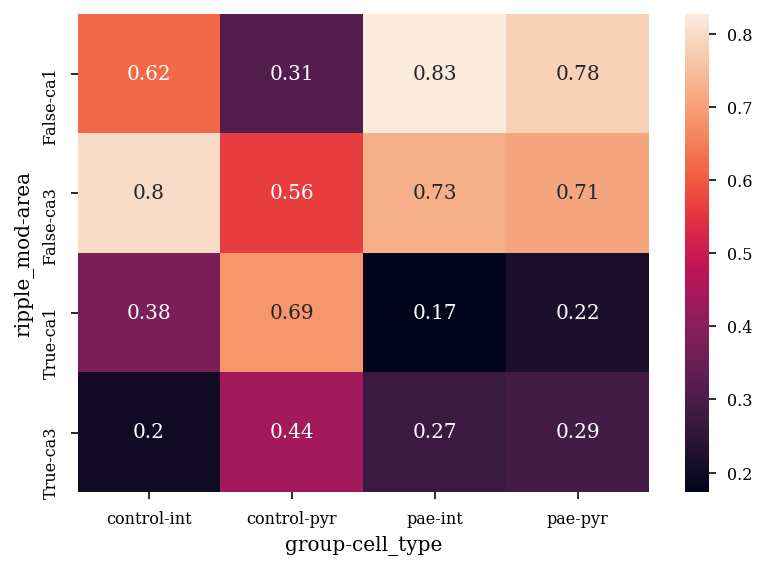

In [297]:
class_counts = pd.crosstab(df_cell_class.ripple_mod[good_cells],[df_cell_class.group[good_cells],df_cell_class.cell_type[good_cells],df_cell_class.area[good_cells]],
                rownames=['ripple_mod'],
                colnames=['group','cell_type','area']).apply(lambda r: r/r.sum(), axis=0).stack()
class_counts
ax = sns.heatmap(class_counts, annot=True)


In [339]:
group = []
area = []
cell_type = []
prop = []

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='int')
group.append('control')
area.append('ca1')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='pyr')
group.append('control')
area.append('ca1')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='int')
group.append('control')
area.append('ca3')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='control') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='pyr')
group.append('control')
area.append('ca3')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))


idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='int')
group.append('pae')
area.append('ca1')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca1') & (df_cell_class.cell_type=='pyr')
group.append('pae')
area.append('ca1')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='int')
group.append('pae')
area.append('ca3')
cell_type.append('int')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))

idx = (df_cell_class.group=='pae') & (df_cell_class.area=='ca3') & (df_cell_class.cell_type=='pyr')
group.append('pae')
area.append('ca3')
cell_type.append('pyr')
prop.append(sum(df_cell_class.ripple_mod[good_cells & idx]) / len(df_cell_class.ripple_mod[good_cells & idx]))


d = {'group': group, 'area': area, 'cell_type': cell_type, 'prop': prop }
df2 = pd.DataFrame(data=d)

df2

,group,area,cell_type,prop
0,control,ca1,int,0.379310
1,control,ca1,pyr,0.685786
2,control,ca3,int,0.200000
3,control,ca3,pyr,0.438217
4,pae,ca1,int,0.172973
5,pae,ca1,pyr,0.216625
6,pae,ca3,int,0.274489
7,pae,ca3,pyr,0.289908


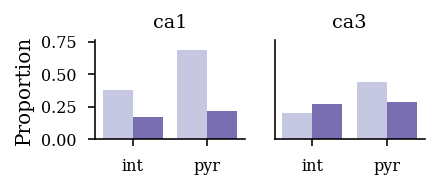

In [364]:
f, ax = plt.subplots(1,2,figsize=set_size('thesis', fraction=0.5, subplots=(1, 2)))
fig.subplots_adjust(hspace = 0, wspace=0)
ax = ax.ravel()

max_value = 0.76

sns.set_palette(sns.color_palette('Purples',2))
sns.barplot(x="cell_type", y="prop",hue = "group", data=df2[df2.area=='ca1'],ax=ax[0],saturation=1,alpha=1)

ax[0].legend([],[], frameon=False)
ax[0].set(ylabel="Proportion")
# sns.despine(trim=False, left=True)
ax[0].set_ylim(0,max_value)
ax[0].set_title('ca1')
ax[0].set_xlabel('')
ax[0].set_yticks(np.arange(0,max_value,.25))


sns.set_palette(sns.color_palette('Purples',2))
g = sns.barplot(x="cell_type", y="prop",hue = "group", data=df2[df2.area=='ca3'],ax=ax[1],saturation=1,alpha=1)
ax[1].legend([],[], frameon=False)
ax[1].set(ylabel="Proportion")
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylim(0,max_value)
ax[1].set_title('ca3')
# ax[1].spines["left"].set_visible(False)
sns.despine(trim=False, right=True)

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\proportions.svg',dpi=300,bbox_inches='tight')


# Participation probability 

D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


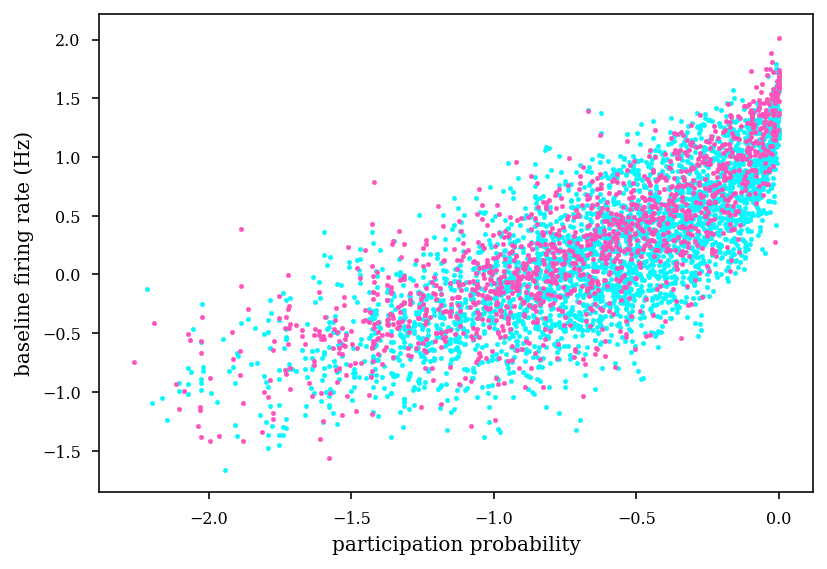

In [356]:
idx = (df_cell_class.cell_type == 'pyr') & good_cells
plt.scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#08F7FE')
idx = (df_cell_class.cell_type == 'int') & good_cells
plt.scatter(np.log10(df_cell_class.participation_prob)[idx],np.log10(df_cell_class.avg_fr)[idx],s=5,color='#FE53BB')
plt.xlabel('participation probability')
plt.ylabel('baseline firing rate (Hz)')
plt.show()

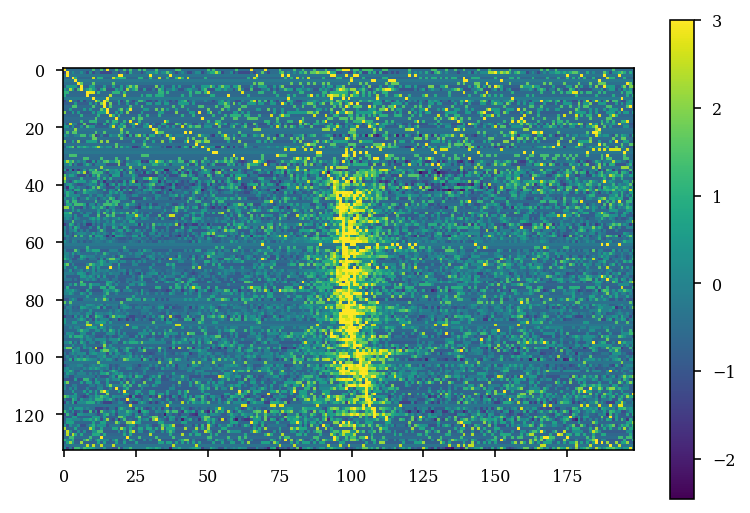

D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


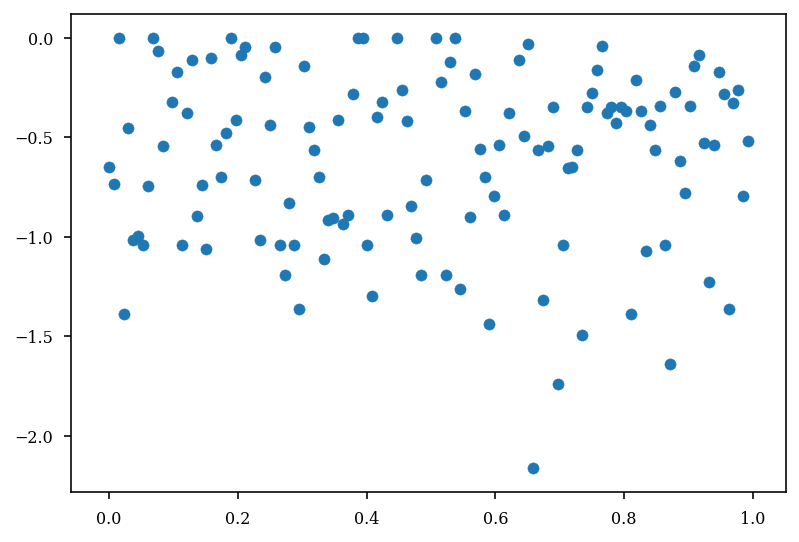

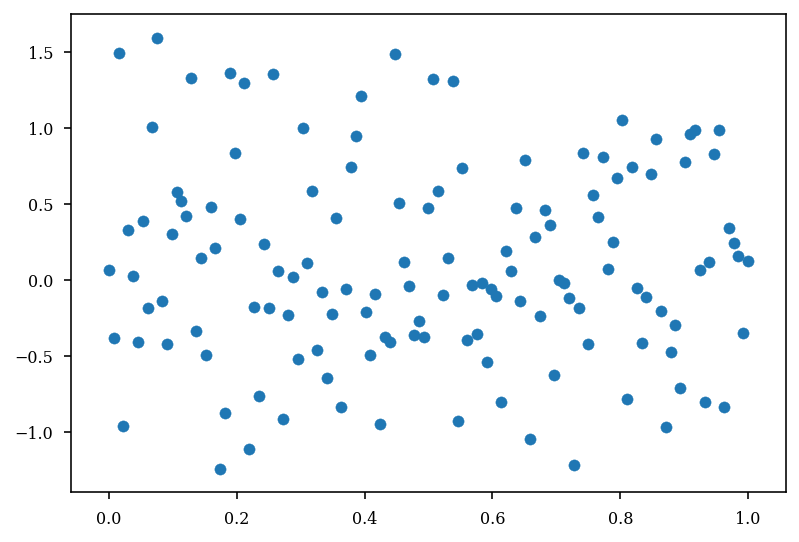

In [78]:
idx = (df_cell_class.session == "LEM3124_S20190302163218") & (df_cell_class.n_spikes >= 100) & (df_cell_class.n_spikes_in_rip_window >= 10)

h0_current = mod_dict['h0_zscore'][idx]
idx = np.argmax(h0_current,axis=1)
idx = np.argsort(idx)


plt.imshow(h0_current[idx],vmax=3)
plt.colorbar()
plt.show()
# vmin=-1.5, vmax=2.5

plt.figure()
plt.scatter(np.linspace(0,1,len(idx)),np.log10(df_cell_class.participation_prob[idx]))

plt.figure()
plt.scatter(np.linspace(0,1,len(idx)),np.log10(df_cell_class.avg_fr[idx]))


## ripple modulation with z score

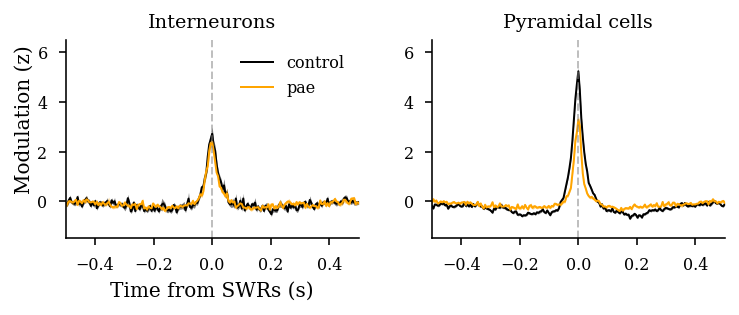

In [39]:
def plot_this_plot(hist,hist_null,idx,ax,label,color,color_2):
    x = np.linspace(-.5,.5,hist.shape[1]) 
    
#     # plot null
#     hist_curr = hist_null[idx]
#     hist_curr = hist_curr[np.sum(np.isnan(hist_curr),axis=1) == 0]
#     ax.plot(x,hist_curr.mean(0), '-',alpha=1, label = label+' null', color = color_2, linewidth = 1)
    
    # plot observed
    hist_curr = hist[idx]
    hist_curr = hist_curr[np.sum(np.isnan(hist_curr),axis=1) == 0]
    m = hist_curr.mean(0)
    v = hist_curr.std(0) / np.sqrt(hist_curr.shape[0])
    ax.plot(x,m, label = label, color = color, linewidth = 1)
    ax.fill_between(x, m-v, m+v, color = color, alpha = 0.5, linewidth = 0)
    


fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=1, subplots=(1,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.25)
axs = axs.ravel()  

idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & (df_cell_class.cell_type == 'int')
plot_this_plot(mod_dict['z'],mod_dict['z_null'],idx,axs[0],'control','black','#1A3947')

idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & (df_cell_class.cell_type == 'int')
plot_this_plot(mod_dict['z'],mod_dict['z_null'],idx,axs[0],'pae','orange','#EFBD9D')

axs[0].set_ylim(-1.5,6.5)

axs[0].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
axs[0].set_xlim(-.5,.5)
axs[0].set_ylabel("Modulation (z)", labelpad = 2, y = 0.6)
axs[0].legend(edgecolor = None, facecolor = None, frameon = False, loc = 'upper right',)
axs[0].set_xlabel('Time from SWRs (s)')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].set_title('Interneurons')


idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control") & (df_cell_class.cell_type == 'pyr')
plot_this_plot(mod_dict['z'],mod_dict['z_null'],idx,axs[1],'control','black','#1A3947')

idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae") & (df_cell_class.cell_type == 'pyr')
plot_this_plot(mod_dict['z'],mod_dict['z_null'],idx,axs[1],'pae','orange','#EFBD9D')

axs[1].set_ylim(-1.5,6.5)

axs[1].axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
axs[1].set_xlim(-.5,.5)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()
axs[1].set_title('Pyramidal cells')

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\z_mod_int_pyr_v2.svg',dpi=900,bbox_inches='tight')
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\z_mod_int_pyr_v2.pdf',dpi=900,bbox_inches='tight')



# compare number of swr modulated interneurons

         sig  notsig
control   74      32
pae       52      67
Chi-squared test statistic without Yates correction (Scipy): 15.515691696918907
P-value without Yates correction (Scipy): 8.182319861814834e-05


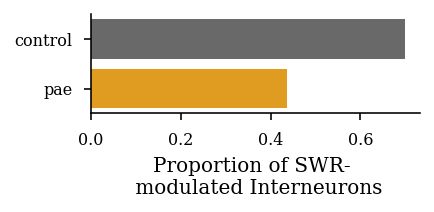

In [80]:
num_sig_control = sum(df_cell_class.sig_center & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & int_idx)
num_sig_pae = sum(df_cell_class.sig_center & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & int_idx)

num_not_sig_control = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & int_idx)
num_not_sig_pae = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & int_idx)

ar = np.array([[num_sig_control,num_not_sig_control],[num_sig_pae,num_not_sig_pae]])
df = pd.DataFrame(ar,columns = ["sig","notsig"])
df.index = ["control","pae"]
print(df)

tstat_scipy,pval_scipy,ddof_scipy,exp_scipy=chi2_contingency(df, correction=False) # "correction=False" means no Yates' correction is used! 
print("Chi-squared test statistic without Yates correction (Scipy): " + str(tstat_scipy))
print("P-value without Yates correction (Scipy): " + str(pval_scipy))

df['porportion'] = df.sig / df.sum(axis=1)

fig, axs = plt.subplots(1,1, figsize=set_size('thesis', fraction=.5, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.5)


# Create an array with the colors you want to use
colors = ['dimgrey','#ffa500ff']

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

ax = sns.barplot(x="porportion", y=df.index, data=df)
plt.xlabel('Proportion of SWR- \n modulated Interneurons')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.show()
# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\porportion_mod_fig.pdf',dpi=900,bbox_inches='tight')
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\porportion_mod_fig.svg',dpi=900,bbox_inches='tight')

         sig  notsig
control  508     239
pae      433     376
Chi-squared test statistic without Yates correction (Scipy): 34.08005385648392
P-value without Yates correction (Scipy): 5.2890654874702135e-09


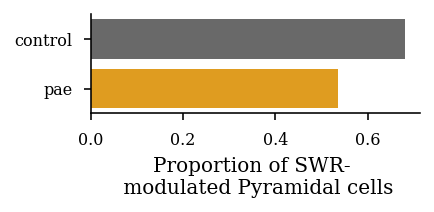

In [82]:
num_sig_control = sum(df_cell_class.sig_center & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & pyr_idx)
num_sig_pae = sum(df_cell_class.sig_center & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & pyr_idx)

num_not_sig_control = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "control") & (df_cell_class.n_ripples >= 100) & pyr_idx)
num_not_sig_pae = sum((df_cell_class.sig_center == False) & (df_cell_class.group == "pae") & (df_cell_class.n_ripples >= 100) & pyr_idx)

ar = np.array([[num_sig_control,num_not_sig_control],[num_sig_pae,num_not_sig_pae]])
df = pd.DataFrame(ar,columns = ["sig","notsig"])
df.index = ["control","pae"]
print(df)

tstat_scipy,pval_scipy,ddof_scipy,exp_scipy=chi2_contingency(df, correction=False) # "correction=False" means no Yates' correction is used! 
print("Chi-squared test statistic without Yates correction (Scipy): " + str(tstat_scipy))
print("P-value without Yates correction (Scipy): " + str(pval_scipy))

df['porportion'] = df.sig / df.sum(axis=1)

fig, axs = plt.subplots(1,1, figsize=set_size('thesis', fraction=.5, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.5)


# Create an array with the colors you want to use
colors = ['dimgrey','#ffa500ff']

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

ax = sns.barplot(x="porportion", y=df.index, data=df)
plt.xlabel('Proportion of SWR- \n modulated Pyramidal cells')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.show()
# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\porportion_mod_fig.pdf',dpi=900,bbox_inches='tight')
plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\porportion_mod_fig.svg',dpi=900,bbox_inches='tight')



# compare SWR energy

(0.13714919930236247, 'negligible')
(-0.6130810841222326, 'large')


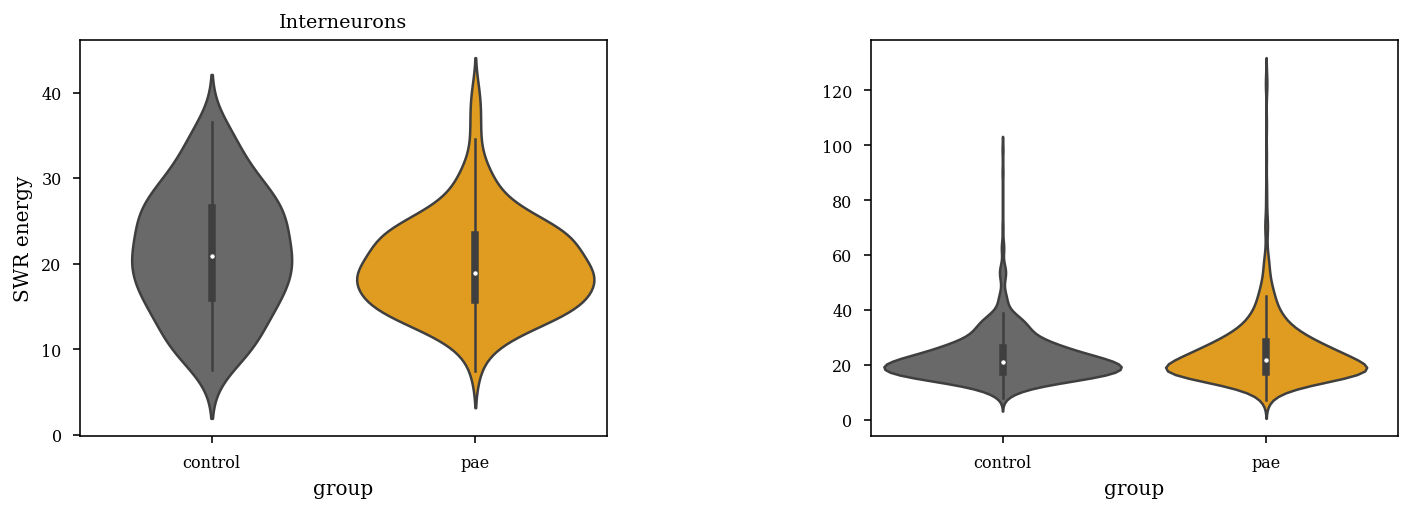

In [50]:
fig, axs = plt.subplots(1,2, figsize=set_size('thesis', fraction=2, subplots=(1, 2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=.5)
axs = axs.ravel()

# set params
x = 'group'
linewidth = 1.25
width = .9

# Create an array with the colors you want to use
colors = ['dimgrey','#ffa500ff']

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

# plot

idx = (df_cell_class.n_ripples >= 100) & int_idx
axs[0] = sns.violinplot(x=x, y="swr_energy", data=df_cell_class[idx],
               linewidth=linewidth,width=width,ax=axs[0])
# axs[0].set_ylim(0,180)

axs[0].set_ylabel('SWR energy')
axs[0].set_title('Pyramidal cells')
axs[0].set_title('Interneurons')
print(cliffsDelta(df_cell_class.swr_energy[idx & (df_cell_class.group == "control")], df_cell_class.swr_energy[idx & (df_cell_class.group == "pae")]))



idx = (df_cell_class.n_ripples >= 100) & pyr_idx

axs[1] = sns.violinplot(x=x, y="swr_energy", data=df_cell_class[idx],
               linewidth=linewidth,width=width,ax=axs[1])
axs[1].set_ylabel('')
# axs[1].set_ylim(0,180)
print(cliffsDelta(df_cell_class.swr_energy[idx & (df_cell_class.group == "control")], df_cell_class.swr_energy[idx & (df_cell_class.group == "pae")]))



# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\SWRenergy_fig.svg',dpi=900,bbox_inches='tight')

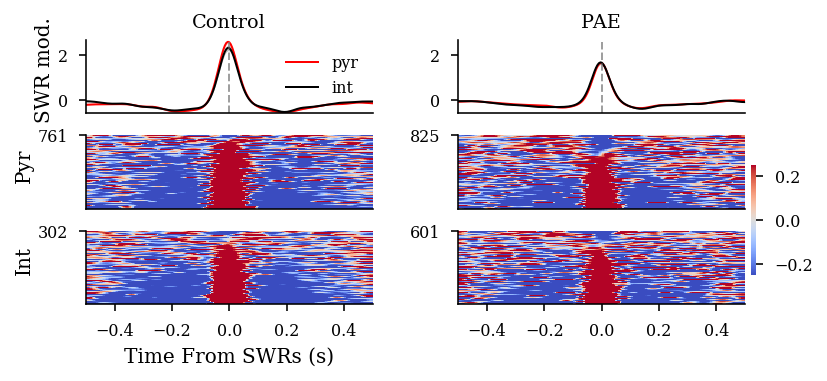

In [51]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def mod_maps(z,df_cell_class,cell_type):
    z_smooth = gaussFilt(z[df_cell_class.cell_type == cell_type,:], (5,))
    z_smooth = np.delete(z_smooth, np.sum(np.isnan(z_smooth),axis=1) > 0, 0)
    idx = np.linspace(-.5,.5,z_smooth.shape[1]) == 0
    z_smooth = z_smooth[np.argsort(z_smooth[:,idx].flatten()),:]
    return z_smooth

def plot_mod_lines(z_smooth,ax,color,cell_type,legend_=0):
    x = np.linspace(-.5,.5,z_smooth.shape[1]) 
    m = z_smooth.mean(0)
    v = z_smooth.std(0) / np.sqrt(z_smooth.shape[0])
    ax.plot(x,z_smooth.mean(0), label = cell_type, color = color, linewidth = 1)
    ax.fill_between(x, m-v, m+v, color = color, alpha = 0.25, linewidth =0)
    ax.axvline(0, linestyle = '--', linewidth = 1, alpha = 0.5, color = 'grey')
    ax.set_xlim(-.5,.5)
    ax.set_ylabel("SWR mod.", labelpad = 2, y = 0.6)
    ax.set_xticks([], [])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    if legend_ == 1:
        ax.legend(edgecolor = None, facecolor = None, frameon = False, loc = 'upper right',)
    return min(m-v), max(m+v)

def plot_mod_maps(z_smooth,ax):
    im = ax.imshow(z_smooth,aspect='auto',cmap = "coolwarm",
              vmin=-.25,vmax=.25,
             extent = [-0.5 , 0.5, 0 , len(z_smooth)])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.set_yticks([len(z_smooth)])
    return im

    
fig, axs = plt.subplots(3,2, figsize=set_size('thesis', fraction=1, subplots=(2,3)), edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=.3)
axs = axs.ravel()    

n_ripples = 100
# plot control
# plot pyr
# idx = df_cell_class.group=="control"
idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "control")

axs[0].set_title('Control')
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"pyr")   
min_mod,max_mod=plot_mod_lines(z_smooth,axs[0],'red',"pyr")
axs[0].set_ylim([min_mod-.03,max_mod+.02])

plot_mod_maps(z_smooth,axs[2])
axs[2].set_ylabel("Pyr", labelpad = 2, y = 0.6)
axs[2].set_xticks([], [])

# plot interneurons
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"int")
plot_mod_lines(z_smooth,axs[0],'black',"int",legend_=1)
plot_mod_maps(z_smooth,axs[4])
axs[4].set_ylabel("Int", labelpad = 2, y = 0.6)
axs[4].set_xlabel('Time From SWRs (s)')

# plot pae
# plot pyr
idx = (df_cell_class.n_ripples >= n_ripples) & (df_cell_class.group == "pae")

# idx = df_cell_class.group=="pae"
axs[1].set_title('PAE')
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"pyr")
plot_mod_lines(z_smooth,axs[1],'red',"pyr")
axs[1].set_ylim([min_mod-.03,max_mod+.02])

plot_mod_maps(z_smooth,axs[3])
axs[3].set_xticks([], [])

# plot interneurons
z_smooth = mod_maps(z[idx,:],df_cell_class[idx],"int")
plot_mod_lines(z_smooth,axs[1],'black',"int")
axs[1].set_ylabel(" ")
im = plot_mod_maps(z_smooth,axs[5])

# add colorbar theme
axins = inset_axes(axs[5],
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, .4, 1, 1.5),
                   bbox_transform=axs[5].transAxes,
                   borderpad=0,
                   )
# plot colorbar
cbar = fig.colorbar(im,ax=axs[5],cax=axins)

# cbar.set_label('Magnitude', rotation=270, labelpad=20)
cbar.outline.set_visible(False)

# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\mod_fig.pdf',dpi=900,bbox_inches='tight')
# plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\neuromatch_conference\mod_fig.svg',dpi=900,bbox_inches='tight')

# plot example raster 

In [ ]:
# session = "LEM3216_S20190805141510"
# # find index of first mention of session
# rip_n = np.where(df_swr.session == session)[0][0]
# # load spikes
# spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# # get ripple times
# peak_time = df_swr.peak_time[df_swr.session == session]

# # [3,7]

In [56]:
session = "LEM3216_S20190726184722"
# find index of first mention of session
rip_n = np.where(df_swr.session == session)[0][0]
# load spikes
spikes = get_spikes(data_path+df_swr.iloc[rip_n].session+'.mat')
# get ripple times
peak_time = df_swr.peak_time[df_swr.session == session]

# [3,7]

In [57]:
display(df_cell_class[df_cell_class.session == session])


,session,tetrode,cell,flipped,peak_to_trough,trough_to_peak,spk_wavelet,local_variation,coeff_variation,short_isi,avg_fr,asymmetry,cell_type,swr_energy,swr_energy_null,group,n_ripples,sig_center
5844,LEM3216_S20190726184722,TT12.mat,114,0,0.359375,0.484375,2.531121,1.516206,1.916434,0.002325,0.978062,1.061003,pyr,21.157111,28.154194,control,121,True
5845,LEM3216_S20190726184722,TT13.mat,116,1,0.234375,0.140625,0.666827,0.876749,1.328792,0.005257,13.764088,4.260927,int,25.245626,15.815460,control,121,True
5846,LEM3216_S20190726184722,TT13.mat,118,1,0.062500,0.375000,1.299161,1.249552,2.605326,0.020650,6.640748,4.857700,pyr,25.580194,18.661603,control,121,True
5847,LEM3216_S20190726184722,TT13.mat,167,1,0.078125,0.359375,1.367552,1.181336,4.279839,0.002756,2.612207,3.961826,pyr,22.516093,25.595085,control,121,True
5848,LEM3216_S20190726184722,TT14.mat,170,0,0.437500,0.328125,2.343644,1.457034,2.342240,0.019858,1.335650,1.218136,pyr,23.919364,24.221121,control,121,False
5849,LEM3216_S20190726184722,TT2.mat,33,1,0.062500,0.093750,0.325149,0.611337,1.305566,0.002857,35.271234,6.374201,int,22.965487,17.439382,control,121,True
5850,LEM3216_S20190726184722,TT6.mat,62,1,0.062500,0.109375,0.431148,0.719024,1.527566,0.001030,29.428239,3.307940,int,27.147826,15.413032,control,121,True
5851,LEM3216_S20190726184722,TT6.mat,66,1,0.359375,0.015625,3.443479,0.600636,1.522760,0.000369,12.311010,0.974856,int,17.968877,15.899051,control,121,False
5852,LEM3216_S20190726184722,TT7.mat,156,1,0.156250,0.312500,2.170054,0.350284,4.436218,0.000151,7.519186,1.782248,pyr,21.933370,20.039996,control,121,False


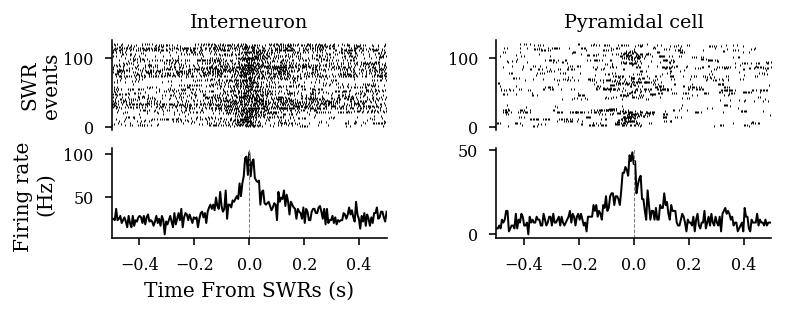

In [69]:
def swr_modulation(spikes,peak_time,binsize=0.005):
    # create raster centered over each ripple with a 1 second window
    x = []
    y = []
    for i,r in enumerate(peak_time):
        idx = (spikes> r - .5) & (spikes < r + .5)
        cur_spks = spikes[idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))

    # bin cell into 5ms bins 
    h0, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,binsize))
    # normalize into firing rate
    h0 = h0 / (len(np.unique(y))*binsize)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(h0,30)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z = (h0 - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z**2))
    return h0, z, swr_energy, x, y

cell_n = 6
# display(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=1, subplots=(1,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.4)
axs = axs.ravel()

axs[0].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
axs[0].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[0].set_xticks([], [])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()
axs[0].set_xlim(-.5,.5)
axs[0].set_title('Interneuron')

axs[2].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
axs[2].set_ylabel('Firing rate \n(Hz)', verticalalignment = 'bottom')
axs[2].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].get_xaxis().tick_bottom()
axs[2].get_yaxis().tick_left()
axs[2].set_xlim(-.5,.5)
axs[2].set_xlabel('Time From SWRs (s)')


cell_n = 2
# display(df_cell_class[df_cell_class.session == session].iloc[cell_n])

# loop through each cell and get modulation 
hist, z_hist, swr_energy, x, y = swr_modulation(spikes[cell_n],peak_time)

axs[1].plot(x,y,'|',color='black',markersize=1,mew = 0.5,rasterized=True)
# axs[1].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[1].set_xticks([], [])
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()
axs[1].set_xlim(-.5,.5)
axs[1].set_title('Pyramidal cell')


axs[3].plot(np.linspace(-0.5,0.5,len(hist)), hist, color='black',linewidth = 1)
# axs[3].set_ylabel('Firing rate (Hz)', verticalalignment = 'bottom')
axs[3].axvline(0,linestyle = '--', color = 'grey', linewidth = 0.5)
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].get_xaxis().tick_bottom()
axs[3].get_yaxis().tick_left()
axs[3].set_xlim(-.5,.5)
# axs[3].set_xlabel('Time From SWRs (s)')

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_section\mod_example_fig_int.svg',dpi=900,bbox_inches='tight')

sig ?  False


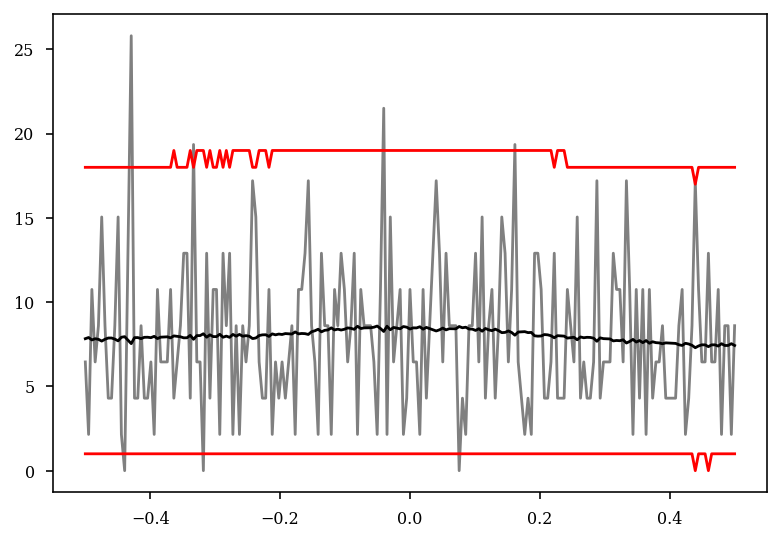

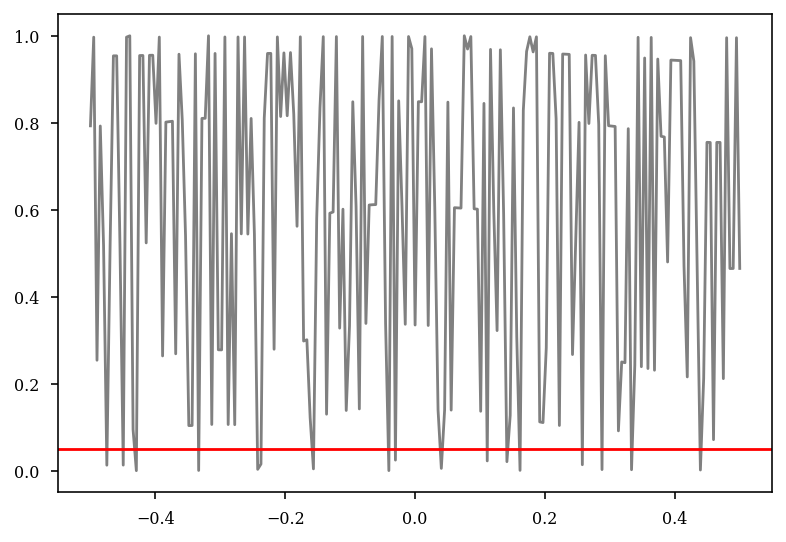

In [231]:
from scipy import signal

def local_firfilt( x, W ):
    C = int(len(W))
    D = int(np.ceil(C / 2) - 1)
    xx = [np.flipud(x[:C]), x, np.flipud(x[-C:])]
    xx = list(itertools.chain(*xx))
    Y = signal.lfilter(W,1,xx)
    Y = Y[C + D : len(Y) - C + D]
    return Y

def local_gausskernel(sigma,N):
    x = np.arange(-(N-1) / 2, ((N-1) / 2) + 1)
    k = 1 / (2*np.pi*sigma) * np.exp(-(x**2 / 2 / sigma**2 ))
    return k

def cch_conv(cch,W=30,HF=0.6):
    # Stark and Abeles JNM 2009
    SDG = W / 2
    if round(SDG)==SDG: # even W
        win = local_gausskernel(SDG, 6 * SDG + 1)
        cidx = int(SDG * 3 + 1)
    else:
        win = local_gausskernel(SDG, 6 * SDG + 2) 
        cidx = int(SDG * 3 + 1.5)
    win[cidx-1] = win[cidx-1] * ( 1 - HF )
    win = win / sum( win )
    pred = local_firfilt( cch, win )
    pvals = 1 - poisson.cdf(cch - 1, pred) - poisson.pmf(cch, pred) * 0.5
    qvals = 1 - pvals
    return pvals, pred, qvals

def sig_mod(cch,binsize=0.005,sig_window=0.2,alpha=0.001):
    pvals, pred, qvals = cch_conv(cch)

    nBonf = int(sig_window/binsize)*2;
    hiBound = poisson.ppf(1-alpha/nBonf, pred)
    loBound = poisson.ppf(alpha/nBonf, pred)

    center_bins = np.arange(int(len(cch)/2 - .1/binsize), int(len(cch)/2 + .1/binsize))
    # at least 3 bins more extreme than bound to be sig
    sig = (sum(cch[center_bins] > max(hiBound))>3) | (sum(cch[center_bins] < min(loBound))>3)
    return sig, hiBound, loBound, pvals, pred

hist, z_hist, swr_energy, x, y = swr_modulation(spikes[8],peak_time)

sig, hiBound, loBound, pvals, pred = sig_mod(hist,alpha=0.05)

plt.figure()
x = np.linspace(-0.5,0.5,len(hist))
plt.plot(x,hist,color='grey')
plt.plot(x,pred,color='k')
plt.plot(x,hiBound,color='r')
plt.plot(x,loBound,color='r')
print('sig ? ',sig)

plt.figure()
plt.plot(x,pvals,color='grey')
plt.axhline(0.05,color='r')

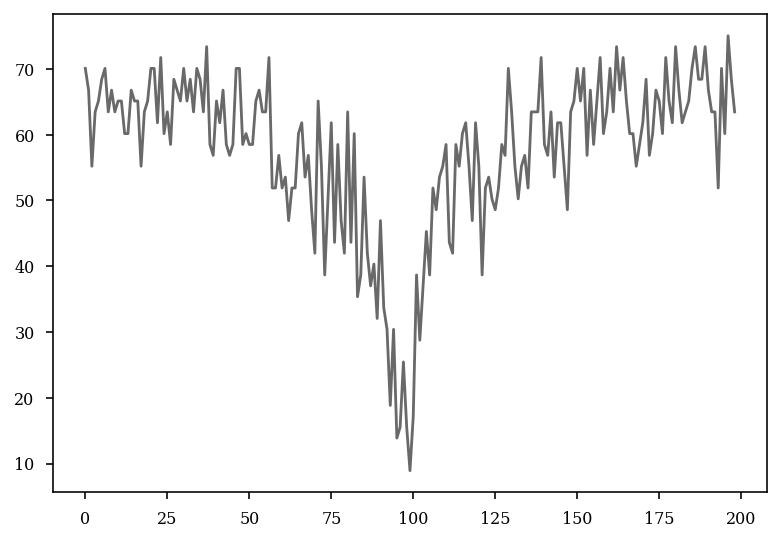

sig ?  True


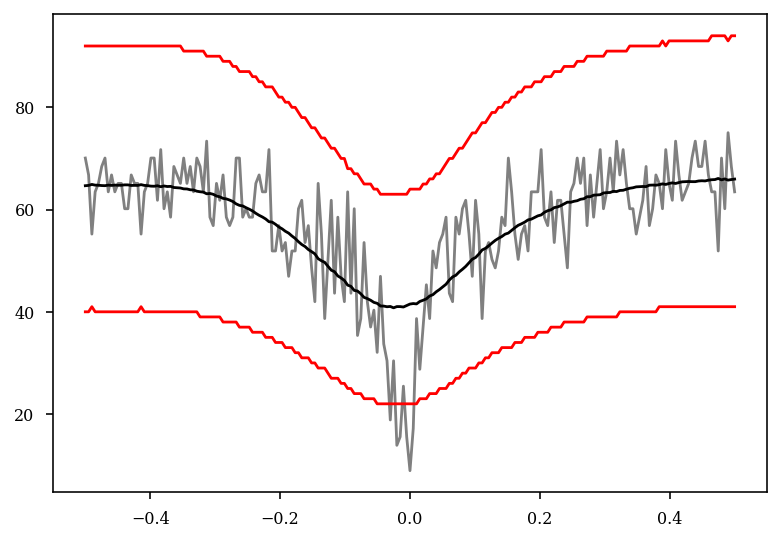

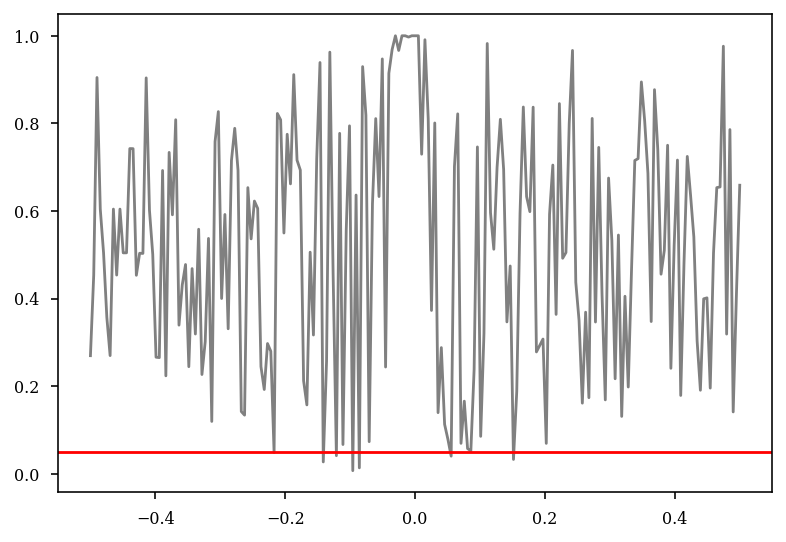

In [215]:
# cch = np.random.rand(199)
# # cch = cch / cch.sum()
# kernal = local_gausskernel(9, 199)
# # cch = (cch * -kernal)+10
# cch = cch+10
# cch = cch * kernal 

cch = -hist + 80
plt.figure()
plt.plot(cch)
plt.show()


sig, hiBound, loBound, pvals, pred = sig_mod(cch,alpha=0.05)

plt.figure()
x = np.linspace(-0.5,0.5,len(cch))
plt.plot(x,cch,color='grey')
plt.plot(x,pred,color='k')
plt.plot(x,hiBound,color='r')
plt.plot(x,loBound,color='r')
print('sig ? ',sig)
plt.figure()
plt.plot(x,pvals,color='grey')
plt.axhline(0.05,color='r')

# testing

In [ ]:
cell = 13
def swr_modulation(spikes,):
    # create raster centered over each ripple with a 1 second window
    x = []
    y = []
    peak_time = df_swr.peak_time[df_swr.session == df_swr.iloc[rip_n].session]
    for i,r in enumerate(peak_time):
        idx = (spikes[cell] > r - .5) & (spikes[cell] < r + .5)
        cur_spks = spikes[cell][idx]
        if any(cur_spks):
            x.append(cur_spks - r)
            y.append(np.ones_like(cur_spks)+i)       
    x = list(itertools.chain(*x))
    y = list(itertools.chain(*y))

    # bin cell into 5ms bins 
    hist, bin_edges = np.histogram(x, bins=np.arange(-0.5,0.5,0.005))
    # normalize into firing rate
    hist = hist / (len(np.unique(y))*0.005)
    # smooth to get expected firing rate
    hist_smooth = gaussian_filter1d(hist,30)
    # subtract the expected rates and devided by the standard deviation to get z-scored modulation
    z_hist = (hist - hist_smooth) / np.sqrt(hist_smooth)
    # Calculate the amplitude of the SWR modulation
    swr_energy = np.sqrt(sum(z_hist**2))

print(swr_energy)

# plot raster, histogram, expected rates, and z-scored modulation
fig, axs = plt.subplots(3,1, figsize=set_size('thesis', fraction=1, subplots=(3,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=1)
axs = axs.ravel()

axs[0].plot(x,y,'|',color='black',markersize=1,mew = 0.5)
axs[0].set_ylabel("SWR\nevents",  multialignment='center',  labelpad = 1)
axs[0].set_xticks([], [])
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].get_xaxis().tick_bottom()
axs[0].get_yaxis().tick_left()

axs[1].plot(np.linspace(-0.5,0.5,len(hist)),gaussFilt(hist, (2,)),color='red',linewidth = 1,label = '')
axs[1].plot(np.linspace(-0.5,0.5,len(hist)),hist_smooth,color='black',linewidth = 1, label = 'Jitter')
axs[1].set_xticks([], [])
axs[1].set_ylabel('Rate \n (Hz)', verticalalignment = 'top', labelpad = 20)
axs[1].legend(edgecolor = None, facecolor = None, frameon = False, loc = 'lower left')	
axs[1].axvline(0, color = 'grey', linewidth = 0.5)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].get_xaxis().tick_bottom()
axs[1].get_yaxis().tick_left()

axs[2].plot(np.linspace(-0.5,0.5,len(z_hist)), gaussFilt(z_hist, (5,)),color='red',linewidth = 1)
axs[2].set_ylabel('Modulation\n(z)', verticalalignment = 'bottom')
axs[2].axvline(0, color = 'grey', linewidth = 0.5)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].get_xaxis().tick_bottom()
axs[2].get_yaxis().tick_left()
